# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Собираем-сиамскую-сеть" data-toc-modified-id="Собираем-сиамскую-сеть-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Собираем сиамскую сеть</a></div><div class="lev1 toc-item"><a href="#Проверяем-глубокое-представление" data-toc-modified-id="Проверяем-глубокое-представление-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Проверяем глубокое представление</a></div>

In [1]:
import numpy as np
import lasagne
import theano
import theano.tensor as T
from lasagne.nonlinearities import rectify, sigmoid, linear, tanh
from lasagne.layers import InputLayer, DenseLayer, BatchNormLayer, Upscale2DLayer, NonlinearityLayer, ReshapeLayer
from lasagne.layers import Conv2DLayer, MaxPool2DLayer, dropout

import matplotlib.pyplot as plt
%matplotlib inline

import gzip
import pickle

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release.  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K40c (CNMeM is disabled, cuDNN 5105)


In [2]:
# Seed for reproducibility
np.random.seed(42)

In [3]:
# Download the MNIST digits dataset
!wget -N http://deeplearning.net/data/mnist/mnist.pkl.gz

--2017-03-13 20:19:07--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Server file no newer than local file 'mnist.pkl.gz' -- not retrieving.



In [4]:
# Load training and test splits as numpy arrays
train, val, test = pickle.load(gzip.open('mnist.pkl.gz'))

X_train, y_train = train
X_val, y_val = val

In [5]:
X_train = X_train.reshape([-1,1,28,28])
X_val = X_val.reshape([-1,1,28,28])

# Собираем сиамскую сеть

In [120]:
input_image_left  = T.tensor4('input_left')
input_center = T.matrix('input_center')

In [121]:
targ_var = T.ivector("target")

In [122]:
l_input = InputLayer(shape=(None, 1, 28, 28), input_var=input_image_left)
c_input = InputLayer(shape=(None, 16), input_var=input_center)

In [123]:
my_nonlin = rectify
nn_l_conv1 = Conv2DLayer(l_input, 32, (3, 3), nonlinearity=my_nonlin, W=lasagne.init.GlorotUniform())
nn_l_pool1 = MaxPool2DLayer(nn_l_conv1, (2, 2))
nn_l_conv2 = Conv2DLayer(nn_l_pool1, 32, (3, 3), nonlinearity=my_nonlin)
nn_l_pool2 = MaxPool2DLayer(nn_l_conv2, (2, 2))
nn_l_dense = DenseLayer(dropout(nn_l_pool2, p=.5), num_units=32, nonlinearity=my_nonlin)
nn_l_out = DenseLayer(dropout(nn_l_dense, p=.5), num_units=16, nonlinearity=my_nonlin)

In [124]:
nn_out  = lasagne.layers.get_output(nn_l_out, deterministic=False)
nn_out_test  = lasagne.layers.get_output(nn_l_out, deterministic=True)

In [125]:
nn_l_sfm = lasagne.layers.DenseLayer(nn_l_out, num_units=10, nonlinearity=lasagne.nonlinearities.softmax)

In [126]:
prediction = lasagne.layers.get_output(nn_l_sfm, deterministic=False)
c_loss = lasagne.objectives.categorical_crossentropy(prediction, targ_var)
c_loss = c_loss.mean()

In [127]:
a = T.scalar()

d1 = T.sum(T.sqr(nn_out - input_center), axis=1)

full_loss = c_loss + a*d1
full_loss = full_loss.mean()

In [128]:
test_prediction = lasagne.layers.get_output(nn_l_sfm, deterministic=True)
test_c_loss = lasagne.objectives.categorical_crossentropy(test_prediction, targ_var)
test_c_loss = test_c_loss.mean()

In [129]:
d1_test = T.sum(T.sqr(nn_out_test - input_center), axis=1)

test_loss = test_c_loss + a*d1_test
test_loss = test_loss.mean()

In [130]:
params = lasagne.layers.get_all_params(nn_l_sfm)
# updates = lasagne.updates.rmsprop(loss, params)
updates = lasagne.updates.adamax(full_loss, params)
# updates = lasagne.updates.nesterov_momentum(loss, params, 0.01)

In [131]:
train_fn = theano.function([input_image_left, input_center, targ_var, a], full_loss, 
                           updates=updates, allow_input_downcast=True)
val_fn = theano.function([input_image_left, input_center, targ_var, a], test_loss, 
                         updates=updates, allow_input_downcast=True)
output_fn = theano.function([input_image_left], nn_out, 
                            allow_input_downcast=True)

In [132]:
def iterate_minibatches(inputs, targets, centers, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt], centers[targets[excerpt]]

In [133]:
def update_centers(centers, out_nn, targets):
    new_centers = np.zeros((10,16))
    for i in np.unique(targets):
        ids = np.where(targets == i)[0]
        xs = out_nn[ids]
        for j in range(xs.shape[0]):
            new_centers[i] += centers[i] - xs[j]
        new_centers[i] /= float(xs.shape[0]+1)
    return new_centers

In [134]:
centers = np.zeros((10,16))

In [135]:
for i in range(centers.shape[0]):
    for j in range(centers.shape[1]):
        centers[i,j] = np.random.randn()

In [136]:
num_epochs = 70
train_errors = []
val_errors = []
epoch = 0
batch_size = 64

margin = 0.9

In [137]:
import time

for epoch in range(epoch, num_epochs):
    
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, centers, batchsize=batch_size, shuffle=True):
        inputs, targs, cents = batch
        err = train_fn(inputs, cents, targs, margin)
        centers = update_centers(centers, output_fn(X_train), targs)
        
        train_err += err
        train_batches += 1
    print err

    val_err = 0
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_train, y_train, centers, batchsize=batch_size, shuffle=True):
        inputs, targs, cents = batch
        err = val_fn(inputs, cents, targs, margin)
        val_err += err
        val_batches += 1

    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
    print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
    train_errors.append(train_err / train_batches)
    val_errors.append(val_err / val_batches)

12.216925621
Epoch 1 of 70 took 359.287s
  training loss:		14.218279
  validation loss:		48.891966
49.9784851074
Epoch 2 of 70 took 359.284s
  training loss:		48.609435
  validation loss:		2.301139
2.29849052429
Epoch 3 of 70 took 359.278s
  training loss:		2.301115
  validation loss:		2.083577
1.30675339699
Epoch 4 of 70 took 359.212s
  training loss:		1.531234
  validation loss:		5.611422
5.35955047607
Epoch 5 of 70 took 359.160s
  training loss:		5.457895
  validation loss:		1.661438
1.65957999229
Epoch 6 of 70 took 359.208s
  training loss:		1.759375
  validation loss:		2.138989
2.19775342941
Epoch 7 of 70 took 359.196s
  training loss:		2.298304
  validation loss:		1.500546
1.72611951828
Epoch 8 of 70 took 359.207s
  training loss:		1.670695
  validation loss:		1.433640
1.62793922424
Epoch 9 of 70 took 359.252s
  training loss:		1.615491
  validation loss:		1.155278
1.22726345062
Epoch 10 of 70 took 359.218s
  training loss:		1.342607
  validation loss:		1.075149
1.12166249752
Epo

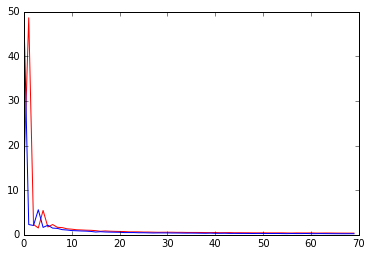

In [138]:
plt.plot(train_errors, 'r')
plt.plot(val_errors, 'b')
plt.show()

# Проверяем глубокое представление

In [139]:
from sklearn import decomposition

In [140]:
from mpl_toolkits.mplot3d import Axes3D

In [141]:
deep_ids = []

In [142]:
for i in range(X_val.shape[0]):
    deep_ids.append(output_fn([X_val[i]])[0])

In [143]:
deep_ids = np.array(deep_ids)

In [153]:
pca = decomposition.PCA(n_components=2)
pca.fit(deep_ids)

PCA(copy=True, n_components=2, whiten=False)

In [154]:
X_val_vis = pca.transform(deep_ids)

In [155]:
np.save('X_val_vis-2D', arr=X_val_vis)

In [156]:
np.save('y_val_vis', arr=y_val)

In [157]:
X_val_vis

array([[-0.01505891, -0.04800579],
       [ 0.05004869,  0.15337729],
       [-0.00091554,  0.0154162 ],
       ..., 
       [ 0.09279574, -0.05968713],
       [-0.00448434,  0.00983286],
       [ 0.02975023,  0.13595186]], dtype=float32)

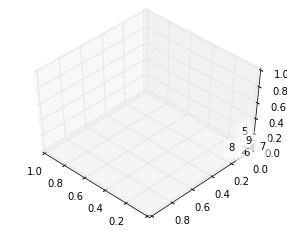

In [149]:
fig = plt.figure(1, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

for label in range(10):
    ax.text3D(X_val_vis[y_val == label, 0].mean(),
              X_val_vis[y_val == label, 1].mean(),
              X_val_vis[y_val == label, 2].mean(), str(label),
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
    
plt.show()

In [150]:
c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff', 
     '#ff00ff', '#990000', '#999900', '#009900', '#009999']

In [158]:
X_vis = X_val_vis

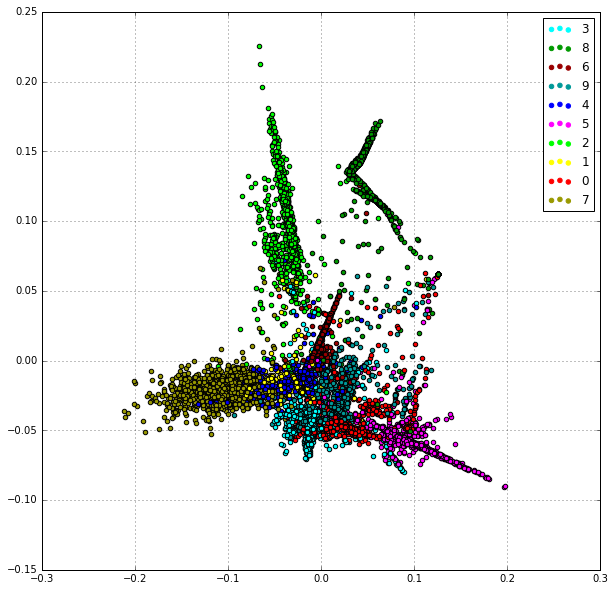

In [159]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

legent_labels = []

for i in range(X_vis.shape[0]):
    if y_val[i] == 0:
        ax.scatter(X_vis[i,0], X_vis[i,1], c=c[0])
        if 0 not in legent_labels:
            legent_labels.append(0)
    if y_val[i] == 1:
        ax.scatter(X_vis[i,0], X_vis[i,1], c=c[1])
        if 1 not in legent_labels:
            legent_labels.append(1)
    if y_val[i] == 2:
        ax.scatter(X_vis[i,0], X_vis[i,1], c=c[2])
        if 2 not in legent_labels:
            legent_labels.append(2)
    if y_val[i] == 3:
        ax.scatter(X_vis[i,0], X_vis[i,1], c=c[3])
        if 3 not in legent_labels:
            legent_labels.append(3)
    if y_val[i] == 4:
        ax.scatter(X_vis[i,0], X_vis[i,1], c=c[4])
        if 4 not in legent_labels:
            legent_labels.append(4)
    if y_val[i] == 5:
        ax.scatter(X_vis[i,0], X_vis[i,1], c=c[5])
        if 5 not in legent_labels:
            legent_labels.append(5)
    if y_val[i] == 6:
        ax.scatter(X_vis[i,0], X_vis[i,1], c=c[6])
        if 6 not in legent_labels:
            legent_labels.append(6)
    if y_val[i] == 7:
        ax.scatter(X_vis[i,0], X_vis[i,1], c=c[7])
        if 7 not in legent_labels:
            legent_labels.append(7)
    if y_val[i] == 8:
        ax.scatter(X_vis[i,0], X_vis[i,1], c=c[8])
        if 8 not in legent_labels:
            legent_labels.append(8)
    if y_val[i] == 9:
        ax.scatter(X_vis[i,0], X_vis[i,1], c=c[9])
        if 9 not in legent_labels:
            legent_labels.append(9)

legent_labels = map(lambda x: str(x), legent_labels)

plt.legend(legent_labels)

leg = ax.get_legend()
for i in range(len(legent_labels)):
    leg.legendHandles[i].set_color(c[int(legent_labels[i])])

plt.grid()
plt.show()
plt.savefig("./MNISTSiamese2D.png", dpi=300)
plt.close()

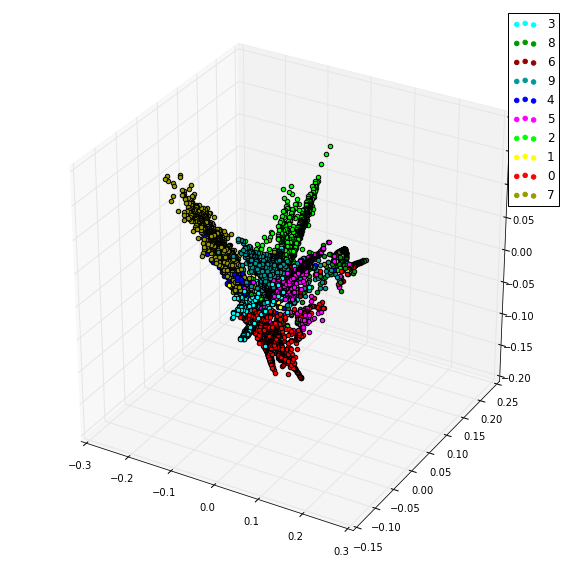

In [152]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

legent_labels = []

for i in range(X_vis.shape[0]):
    if y_val[i] == 0:
        ax.scatter(X_vis[i,0], X_vis[i,1], X_vis[i,2], c=c[0])
        if 0 not in legent_labels:
            legent_labels.append(0)
    if y_val[i] == 1:
        ax.scatter(X_vis[i,0], X_vis[i,1], X_vis[i,2], c=c[1])
        if 1 not in legent_labels:
            legent_labels.append(1)
    if y_val[i] == 2:
        ax.scatter(X_vis[i,0], X_vis[i,1], X_vis[i,2], c=c[2])
        if 2 not in legent_labels:
            legent_labels.append(2)
    if y_val[i] == 3:
        ax.scatter(X_vis[i,0], X_vis[i,1], X_vis[i,2], c=c[3])
        if 3 not in legent_labels:
            legent_labels.append(3)
    if y_val[i] == 4:
        ax.scatter(X_vis[i,0], X_vis[i,1], X_vis[i,2], c=c[4])
        if 4 not in legent_labels:
            legent_labels.append(4)
    if y_val[i] == 5:
        ax.scatter(X_vis[i,0], X_vis[i,1], X_vis[i,2], c=c[5])
        if 5 not in legent_labels:
            legent_labels.append(5)
    if y_val[i] == 6:
        ax.scatter(X_vis[i,0], X_vis[i,1], X_vis[i,2], c=c[6])
        if 6 not in legent_labels:
            legent_labels.append(6)
    if y_val[i] == 7:
        ax.scatter(X_vis[i,0], X_vis[i,1], X_vis[i,2], c=c[7])
        if 7 not in legent_labels:
            legent_labels.append(7)
    if y_val[i] == 8:
        ax.scatter(X_vis[i,0], X_vis[i,1], X_vis[i,2], c=c[8])
        if 8 not in legent_labels:
            legent_labels.append(8)
    if y_val[i] == 9:
        ax.scatter(X_vis[i,0], X_vis[i,1], X_vis[i,2], c=c[9])
        if 9 not in legent_labels:
            legent_labels.append(9)

legent_labels = map(lambda x: str(x), legent_labels)

plt.legend(legent_labels)

leg = ax.get_legend()
for i in range(len(legent_labels)):
    leg.legendHandles[i].set_color(c[int(legent_labels[i])])
    
plt.grid()
plt.show()
plt.savefig("./MNISTSiamese3D.png", dpi=300)
plt.close()